In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfm = tf.linalg

@tf.function
def renyi_gauss_student_objective_B_gevd(
    mu_f,               # [n]     mean of q(f)
    Sigma_f,            # [n,n]   covariance of q(f)
    K,                  # [n,n]   TARGET marginal covariance of Student-t (not scale)
    nu,                 # scalar  dof of Student-t
    alpha,              # scalar  Renyi parameter (alpha > 0, alpha != 1)
    num_r_samples=256,  # number of Monte Carlo samples for r ~ p(r)
    jitter=1e-6,        # numerical jitter for Cholesky/eig
    dtype=tf.float64,
):
    """
    Computes D_alpha( q(f) p(r) || p(f|r) p(r) ) for Objective B using the GEVD-efficient form.
    Here: p(f|r) = N(0, r * Sigma), with Sigma = ((nu - 2)/nu) * K so that Cov_t(f) = K.
          q(f)   = N(mu_f, Sigma_f), independent of r.
          p(r)   = InvGamma(nu/2, nu/2).  (equivalently r^{-1} ~ Gamma(nu/2, nu/2))

    Returns:
        D_alpha: scalar tf.float64
        aux: dict of useful intermediates (optional inspection)
    """
    mu_f   = tf.convert_to_tensor(mu_f,   dtype=dtype)        # [n]
    Sigma_f= tf.convert_to_tensor(Sigma_f,dtype=dtype)         # [n,n]
    K      = tf.convert_to_tensor(K,      dtype=dtype)         # [n,n]
    nu     = tf.convert_to_tensor(nu,     dtype=dtype)
    alpha  = tf.convert_to_tensor(alpha,  dtype=dtype)

    n = tf.cast(tf.shape(Sigma_f)[0], dtype)

    # --- Student-t covariance decomposition: Sigma (the Gaussian scale inside the mixture)
    Sigma = ((nu - 2.) / nu) * K

    # --- Cholesky of Sigma_f (stable)
    Sigma_f_j = Sigma_f + jitter * tf.eye(tf.shape(Sigma_f)[0], dtype=dtype)
    L = tfm.cholesky(Sigma_f_j)  # Sigma_f = L L^T

    # Compute tilde_Sigma = L^{-1} Sigma L^{-T}
    Linv = tfm.triangular_solve(L, tf.eye(tf.shape(L)[0], dtype=dtype))  # L^{-1}
    tilde_Sigma = Linv @ Sigma @ tf.transpose(Linv)

    # Eigendecomposition of symmetric tilde_Sigma = V diag(lambda) V^T
    # (V orthonormal, lambda >= 0)
    eigvals, V = tfm.eigh(tilde_Sigma)  # eigvals: [n], V: [n,n]
    lam = tf.maximum(eigvals, tf.zeros_like(eigvals))  # guard against tiny negatives

    # Q = L^{-T} V, so Q^{-1} = V^T L^T
    # v := Q^{-1} mu_f = V^T L^T mu_f
    v = tf.einsum("ij,j->i", tf.transpose(V), tf.einsum("ij,j->i", tf.transpose(L), mu_f))


    # Determinant constants outside the expectation:
    # log|Q|^{-1} = log|L| = 0.5 * log|Sigma_f|
    sign_Sf, logdet_Sf = tfm.slogdet(Sigma_f_j)  # should be +1
    # log|Sigma| term:
    Sigma_j = Sigma + jitter * tf.eye(tf.shape(Sigma)[0], dtype=dtype)
    sign_S, logdet_S = tfm.slogdet(Sigma_j)

    # Distribution for r ~ InvGamma(nu/2, nu/2)
    p_r = tfd.InverseGamma(concentration=nu/2., scale=nu/2.)

    # Sample r
    r = p_r.sample(int(num_r_samples), seed=None)  # [S]
    r = tf.maximum(r, tf.cast(1e-16, dtype))       # clip for safety
    log_r = tf.math.log(r)                         # [S]

    # For each sample, build diagonal (alpha * r * lam + 1)
    # lam: [n], r: [S]  -> broadcast to [S, n]
    diag_terms = alpha * tf.expand_dims(r, -1) * tf.expand_dims(lam, 0) + 1.0  # [S, n]

    # |M|^{-1/2} = prod_i (alpha * r * lam_i + 1)^{-1/2}  -> log factor
    log_det_M_neg_half = -0.5 * tf.reduce_sum(tf.math.log(diag_terms), axis=1)  # [S]

    # Quadratic term: v^T M^{-1} v = sum_i v_i^2 / (alpha * r * lam_i + 1)
    v2 = tf.square(v)                                # [n]
    quad = tf.reduce_sum(v2[None, :] / diag_terms, axis=1)  # [S]

    # r^{alpha * n/2} term from |r Sigma|^{alpha/2} -> (r^{n})^{alpha/2} = r^{alpha n/2}
    r_power = (alpha * n / 2.0) * log_r              # [S]

    # Combine inside the expectation:
    # exp( 0.5*(alpha-1)*alpha * quad ) * |M|^{-1/2} * r^{alpha n/2}
    log_weight = 0.5 * (alpha - 1.0) * alpha * quad + log_det_M_neg_half + r_power  # [S]
    # For numerical stability, use log-mean-exp
    max_lw = tf.reduce_max(log_weight)
    mean_exp = tf.reduce_mean(tf.exp(log_weight - max_lw))
    log_expectation = max_lw + tf.math.log(mean_exp + tf.cast(1e-300, dtype))

    # Constants that sit outside the expectation inside the log:
    # log|Q|^{-1} + (alpha/2)log|Sigma| + ((1-alpha)/2)log|Sigma_f|
    const_logs = (0.5 * logdet_Sf) + (alpha / 2.0) * logdet_S + ((1.0 - alpha) / 2.0) * logdet_Sf

    # D_alpha = (1/(alpha-1)) * [ log( E_r[ ... ] ) + const_logs ]
    D_alpha = (1.0 / (alpha - 1.0)) * (log_expectation + const_logs)

    aux = {
        "eigvals_lambda": lam,
        "v": v,
        "logdet_Sigma_f": logdet_Sf,
        "logdet_Sigma": logdet_S,
        "log_expectation_r": log_expectation,
        "num_r_samples": tf.cast(num_r_samples, dtype),
    }
    return D_alpha, aux


# ---- Example usage (dummy shapes) ----
if __name__ == "__main__":
    tf.random.set_seed(0)
    n = 50
    # Build SPD matrices
    A = tf.random.normal((n, n), dtype=tf.float64)
    Sigma_f = A @ tf.transpose(A) + 1e-3 * tf.eye(n, dtype=tf.float64)

    B = tf.random.normal((n, n), dtype=tf.float64)
    K = B @ tf.transpose(B) + 1e-3 * tf.eye(n, dtype=tf.float64)

    mu_f = tf.random.normal((n,), dtype=tf.float64)

    nu = tf.constant(7.0, tf.float64)      # dof > 2
    alpha = tf.constant(0.5, tf.float64)   # example α (not 1)

    D_alpha, aux = renyi_gauss_student_objective_B_gevd(
        mu_f=mu_f,
        Sigma_f=Sigma_f,
        K=K,
        nu=nu,
        alpha=alpha,
        num_r_samples=512,
    )
    # Print the scalar divergence
    tf.print("D_alpha =", D_alpha)


D_alpha = 66.850374520658193


In [2]:
import gpflow
class GVI_TP_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y, Kernel, Sigma_f_structure="c_f",
                 inducing=[.0], alpha=0.5,
                 sigma=.25):
        super().__init__()
        self.X = X
        self.y = y

        # define if we are gonna optimize through the GVI or predictive.
        self.alpha = gpflow.Parameter(alpha, trainable=False)

        self.sigma = gpflow.Parameter(sigma, transform=gpflow.utilities.positive())
        # define the type of objective

        # GP parameters
        self.kernel = Kernel
        self.inducing_variable = inducing

        # set structure for \Sigma_f
        if Sigma_f_structure == "c_f":
            self.c_f = gpflow.Parameter(1., transform=gpflow.utilities.positive(), trainable=True)
        else:
            self.Kernel_inducing = gpflow.kernels.SquaredExponential(lengthscales=0.1, variance=0.1)
        self.Sigma_f_structure = Sigma_f_structure
        
    tf.keras.backend.set_floatx('float64')

    # needed for the class
    def maximum_log_likelihood_objective(self):
        pass

    # update Sigma_f according to method.
    @tf.function
    def compute_sigma_f(self, X):
        if self.Sigma_f_structure == "c_f":
            K = self.kernel(X, X)
            eye = tf.eye(tf.shape(K)[0], dtype=K.dtype)
            Sigma_f = self.c_f * K @ tf.linalg.inv(K + self.sigma ** 2 * eye) * self.sigma ** 2
        else:
            K = self.kernel(X, X)
            K_uu = self.Kernel_inducing(self.inducing_variable, self.inducing_variable)
            K_uf = self.Kernel_inducing(self.inducing_variable, X)
            K_fu = tf.transpose(K_uf)
            K_uu_inv = tf.linalg.inv(K_uu + tf.linalg.eye(K_uu.shape[0], dtype=tf.float64) * gpflow.default_jitter())
            Sigma_f = K_fu @ K_uu_inv @ K_uf
        return K, Sigma_f


    def log_likelihood_loss(self, y, mu_f, sigma_f):
        loss = 0.5 * tf.transpose(y - mu_f) @ (y - mu_f) * (self.sigma ** (-2) )
        loss += len(y) * tf.math.log(self.sigma)
        loss += 0.5 * self.sigma ** (-2) * tf.reduce_sum(sigma_f)
        return loss

    def GVI_step(self):
        K, Sigma_f = self.compute_sigma_f(self.X)

        N = tf.cast(tf.shape(K)[0], tf.float64)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye / self.sigma ** 2 )
        q2 = tf.matmul(eye / self.sigma ** 2 , self.y)
        mu_f = tf.matmul(q1, q2)

        #loss
        term1 = self.log_likelihood_loss(self.y, mu_f, tf.linalg.trace(Sigma_f))
        #divergence
        divergence = self.renyi_gauss_student_objective_B_gevd(
    mu_f=tf.squeeze(mu_f),   # ensure vector
    Sigma_f=Sigma_f,
    K=K,
    nu=5.0,                  # or make this a class param
    alpha=self.alpha,
    num_r_samples=128
)
        loss = tf.squeeze(term1 + divergence)

        return loss




    def predict_ins(self):
        K, Sigma_f = self.compute_sigma_f(self.X)

        N = tf.cast(tf.shape(K)[0], tf.float64)

        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye / self.sigma ** 2)
        q2 = tf.matmul(eye / self.sigma ** 2, self.y)
        mu_f = tf.matmul(q1, q2)
        self.mu_f = mu_f
        self.Sigma_f = Sigma_f
        self.K = K

    def renyi_gauss_student_objective_B_gevd(self, mu_f, Sigma_f, K, nu, alpha, num_r_samples=256, jitter=1e-6):
        """
        Computes D_alpha(q||p) for Objective B (q(f) q(r), q(r)=p(r)) using GEVD trick.
        """
        n = tf.shape(K)[0]
        dtype = K.dtype
        I = tf.eye(n, dtype=dtype)
        jitter = 0.00001
    
        # Cholesky of K
        L = tf.linalg.cholesky(K + jitter * I)
    
        # Transform Sigma_f into K^{-1/2} basis
        K_inv_sqrt = tf.linalg.inv(L)
        tilde_Sigma = K_inv_sqrt @ Sigma_f @ tf.transpose(K_inv_sqrt)
    
        # Eigen-decomposition
        eigvals, V = tf.linalg.eigh(tilde_Sigma)
        lam = tf.maximum(eigvals, 0.0)  # ensure nonneg
    
        # transform mean into eigenbasis
        mu_f_col = tf.expand_dims(mu_f, -1)                   # [n,1]
        v_col = tf.transpose(V) @ (tf.transpose(L) @ mu_f_col)  # [n,1]
        v = tf.squeeze(v_col, -1)                             # [n]
    
        # log|Sigma_f|
        _, logdet_Sf = tf.linalg.slogdet(Sigma_f + jitter*I)
    
        # sample r ~ InvGamma(nu/2, nu/2)
        gamma_samples = tf.random.gamma([num_r_samples], alpha=nu/2.0, beta=nu/2.0, dtype=dtype)
        r_samples = 1.0 / gamma_samples   # [S]
    
        # compute inside expectation
        def body(r_j):
            # M = I + (alpha/(nu*r)) Lambda
            M_diag = 1.0 + (alpha/(nu*r_j)) * lam
            logdet_M = tf.reduce_sum(tf.math.log(M_diag))
    
            invM_diag = 1.0 / M_diag
            quad_form = tf.reduce_sum(invM_diag * (v**2))
    
            return -0.5*logdet_M - (alpha/(2.0*nu*r_j))*quad_form
    
        vals = tf.map_fn(body, r_samples)
    
        # log expectation via log-mean-exp trick
        m = tf.reduce_max(vals)
        log_E = m + tf.math.log(tf.reduce_mean(tf.exp(vals - m)))
    
        logJ = -0.5*logdet_Sf + log_E
        D_alpha = (1.0/(alpha-1.0)) * logJ
        return D_alpha


    def internal_opt(self, n_it=10):
        optimizer = tf.optimizers.Adam(learning_rate=0.01)
        for i in range(n_it):
            with tf.GradientTape(persistent=True) as tape:
                loss = self.GVI_step()
            grads = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))
        opt = gpflow.optimizers.Scipy()
        opt.minimize(self.GVI_step, self.trainable_variables)

    def predict_out(self, X):
        K_xold_xold = self.kernel(self.X, self.X)
        K_xold_xnew = self.kernel(X, self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K_xold_xold)[0], dtype=K_xold_xold.dtype)
        K_inv = tf.linalg.inv(K_xold_xold + jitter)

        #compute variance
        f_var = self.kernel(X,X) - K_xold_xnew @ K_inv @ tf.transpose(K_xold_xnew)+ K_xold_xnew @ K_inv @ self.Sigma_f @ K_inv @ tf.transpose(K_xold_xnew)
        return K_xold_xnew @ K_inv @ self.mu_f, tf.linalg.diag_part(f_var)




(0.0, 20.0)

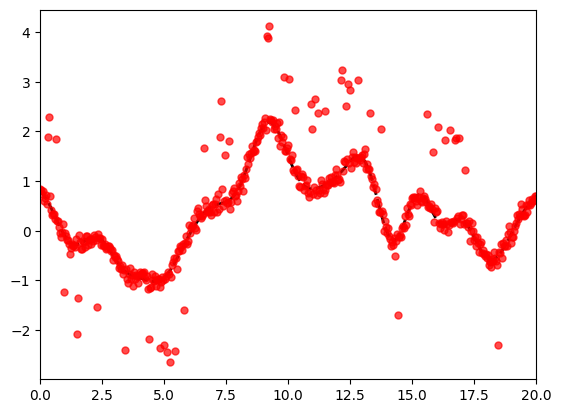

In [3]:
from typing import Optional

import tensorflow as tf
import numpy as np
from check_shapes import check_shapes, inherit_check_shapes
from typing import Optional, Tuple, Type, Union, cast
import tensorflow_probability as tfp
import gpflow

from gpflow.base import InputData, MeanAndVariance, RegressionData, TensorData
from gpflow.kernels import Kernel
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models.model import GPModel
from gpflow.models.training_mixins import InternalDataTrainingLossMixin
from gpflow.models.util import data_input_to_tensor
from gpflow.config import default_float, default_jitter
from gpflow.utilities import to_default_float
from gpflow import posteriors
from gpflow.utilities.ops import eye
import random

from numpy.lib.twodim_base import histogram2d
from tensorboard.plugins.histogram.summary import histogram
from tensorflow.python.ops.variables import trainable_variables

import w 

import tensorflow as tf
import numpy as np
import gpflow

import matplotlib.pyplot as plt
tf.keras.config.set_floatx('float64')
seed = 10

#set seed
np.random.seed(seed)
tf.random.set_seed(seed)

#create X
n_points = 500
sigma_n = 0.1
#percentage of points in x which are biased
percent_miss=0.1


#
lengthscale = 1
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int( n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=n_points).reshape(n_points, 1)
x_obs = x[i_obs]

arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_mis = np.random.choice(
    np.arange(0, n_points, 1), int(percent_miss * n_points), replace=False)

upp=2
low=1
y_mis_pos = y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]]  + np.random.uniform(low, upp, size=len(i_mis[(y_obs[i_mis]>0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]>0)[:,0]]),1)
y_mis_neg = y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]]  - np.random.uniform(low, upp, size=len(i_mis[(y_obs[i_mis]<=0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]<=0)[:,0]]),1)
y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]] = y_mis_pos
y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]] = y_mis_neg
X=x
y=y_obs

plt.plot(x, f, color='black', ls='--', lw=2)
plt.plot(x_obs, y_obs, 'r.', ms=10, alpha=0.7)
plt.xlim(x[0], x[-1])

In [4]:
N=X.shape[0]
Z =X[np.random.choice(N, 20, replace=False), :]
kernel = gpflow.kernels.SquaredExponential(lengthscales=1.0, variance=1.0)
inducing_variable = gpflow.Parameter(Z,trainable=False)
model = GVI_TP_alpha(X,y,kernel)
model.internal_opt()
model.predict_ins()
tf.reduce_mean((model.mu_f - f) ** 2)

<tf.Tensor: shape=(), dtype=float64, numpy=0.036514996172299904>

In [5]:
model.trainable_variables

(<tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.3747229193563665>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-0.34450834253445517>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.6908008861551396>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.2865892312465057>)

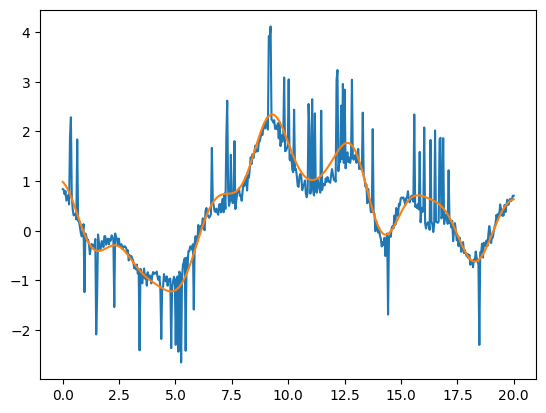

In [6]:
plt.plot(X,y)
plt.plot(X,model.mu_f)

In [42]:
import gpflow
class GVI_STP_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y, Kernel,
                 inducing=[.0], alpha=0.5,structure="Tri",
                 sigma=.25):
        super().__init__()
        self.X = X
        self.y = y
        self.N_u=inducing.shape[0]
        # define if we are gonna optimize through the GVI or predictive.
        self.alpha = gpflow.Parameter(alpha, trainable=False)

        self.sigma = gpflow.Parameter(sigma, transform=gpflow.utilities.positive())
        # define the structure
        if structure == "Diag":
            self.Var_q = gpflow.Parameter([1.] * self.N_u, transform=gpflow.utilities.positive())
        else:
            self.Var_q = gpflow.Parameter(tf.linalg.eye(self.N_u), transform=gpflow.utilities.triangular())
    
        self.structure = structure
        # GP parameters
        self.kernel = Kernel
        self.inducing_variable = inducing
        
    tf.keras.backend.set_floatx('float64')

    # needed for the class
    def maximum_log_likelihood_objective(self):
        pass


    def log_likelihood_loss(self, y, mu_f, sigma_f):
        loss = 0.5 * tf.transpose(y - mu_f) @ (y - mu_f) * (self.sigma ** (-2) )
        loss += len(y) * tf.math.log(self.sigma)
        loss += 0.5 * self.sigma ** (-2) * tf.reduce_sum(sigma_f)
        return loss

    def GVI_step(self):
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        # Invert via stable_solve
        jitter = tf.eye(K_uu.shape[0], dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu + jitter)

        # Variational covariances
        if self.structure == "Diag":
            Sigma_u = tf.linalg.diag(self.Var_q)
        else:
            Sigma_u = self.Var_q @ tf.transpose(self.Var_q)

        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        precision_mid = self.alpha * Sigma_a_inv + (
                        K_uu_inv @ K_uf @ K_fu @ K_uu_inv) / self.sigma ** 2 
        q1 = tf.linalg.inv(precision_mid + jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf,self.y) / (self.sigma ** 2)
        # Compute mu_u
        mu_u = tf.matmul(q1, q2)
        
        
        Variance_pred=tf.linalg.diag_part(self.kernel(X, X) - K_fu @ K_uu_inv  @ K_uf + K_fu @ K_uu_inv @ Sigma_u @ K_uu_inv @ K_uf)
        #loss
        term1 = self.log_likelihood_loss(self.y, K_fu@K_uu_inv@mu_u, Variance_pred)
        #divergence
        divergence = self.renyi_gauss_student_objective_B_gevd(
    mu_f=tf.squeeze(mu_u),   # ensure vector
    Sigma_f=Sigma_u,
    K=K_uu,
    nu=5.0,                  # or make this a class param
    alpha=self.alpha,
    num_r_samples=128
)
        loss = tf.squeeze(term1 - divergence)

        return loss




    def predict_ins(self):
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu + jitter)

        # Variational covariances
        if self.structure == "Diag":
            Sigma_u = tf.linalg.diag(self.Var_q)
        else:
            Sigma_u = self.Var_q @ tf.transpose(self.Var_q)

        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        precision_mid = self.alpha * Sigma_a_inv + (
                        K_uu_inv @ K_uf @ K_fu @ K_uu_inv) / self.sigma ** 2 
        q1 = tf.linalg.inv(precision_mid + jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf,self.y) / (self.sigma ** 2)
        # Compute mu_u
        mu_u = tf.matmul(q1, q2)
        self.mu_u = mu_u
        self.Sigma_u = Sigma_u
        self.K_uu = K_uu

    @tf.function
    def renyi_gauss_student_objective_B_gevd(
    self,
    mu_f,            # [n] vector
    Sigma_f,         # [n,n]
    K,               # [n,n] marginal covariance K
    nu,              # scalar dof
    alpha,           # scalar
    num_r_samples=256,
    jitter=1e-6,
    ):
        """
        Returns D_alpha(q(f) p(r) || p(f|r) p(r)) using GEVD + MonteCarlo in r.
        Uses: p(f|r)=N(0, r * Sigma) with Sigma = (nu-2)/nu * K  so Cov_t(f)=K.
        """
        dtype = K.dtype
        n = tf.shape(K)[0]
        n_f = tf.cast(n, dtype)
    
        # Sigma inside the Gaussian mixture (so that E[r] * Sigma = K)
        Sigma = ((nu - 2.0) / nu) * K
    
        # Cholesky of Sigma_f (stable)
        Sigma_f_j = Sigma_f + jitter * tf.eye(n, dtype=dtype)
        L = tf.linalg.cholesky(Sigma_f_j)                # L L^T = Sigma_f
    
        # compute tilde_Sigma = L^{-1} Sigma L^{-T}
        Linv = tf.linalg.triangular_solve(L, tf.eye(n, dtype=dtype))
        tilde_Sigma = Linv @ Sigma @ tf.transpose(Linv)
    
        # eigen-decomposition tilde_Sigma = V diag(lam) V^T
        lam, V = tf.linalg.eigh(tilde_Sigma)             # lam: [n]
    
        lam = tf.maximum(lam, tf.zeros_like(lam))        # numerical safety
    
        # v = Q^{-1} mu_f with Q = L^{-T} V  ->  v = V^T L^T mu_f
        mu_col = tf.expand_dims(mu_f, -1)                # [n,1]
        v_col = tf.transpose(V) @ (tf.transpose(L) @ mu_col)  # [n,1]
        v = tf.squeeze(v_col, -1)                        # [n]
        v2 = tf.square(v)                                # [n]
    
        # log-dets for constants (use slogdet)
        sign_Sigma, logdet_Sigma = tf.linalg.slogdet(Sigma + jitter * tf.eye(n, dtype=dtype))
        sign_Sigma_f, logdet_Sigma_f = tf.linalg.slogdet(Sigma_f_j)
    
        # sample r ~ InvGamma(nu/2, nu/2) by sampling gamma then invert
        # shape must be integer shape vector
        gamma = tf.random.gamma(shape=[num_r_samples], alpha=nu/2.0, beta=nu/2.0, dtype=dtype)
        r_samples = 1.0 / gamma                                        # [S]
        r_samples = tf.maximum(r_samples, tf.cast(1e-16, dtype))      # clip
    
        # Build diag terms: diag_i = alpha * r * lam_i + (1 - alpha)
        # Shapes: r_samples [S], lam [n] -> broadcast to [S,n]
        r_exp = tf.expand_dims(r_samples, axis=1)                     # [S,1]
        lam_row = tf.expand_dims(lam, axis=0)                         # [1,n]
        diag_terms = alpha * r_exp * lam_row + (1.0 - alpha)          # [S,n]
    
        # log |diag_terms| sum
        log_det_terms = tf.reduce_sum(tf.math.log(diag_terms), axis=1)       # [S]
        # quadratic form v^T (diag(inv diag_terms)) v = sum v_i^2 / diag_terms
        quad = tf.reduce_sum(v2[None, :] / diag_terms, axis=1)               # [S]
    
        # r^{alpha * n / 2} piece
        log_r = tf.math.log(r_samples)
        r_power = (alpha * n_f / 2.0) * log_r                                 # [S]
    
        # exponent part: (alpha(α-1)/2) * quad  and -0.5 * log_det_terms
        log_weight = 0.5 * alpha * (alpha - 1.0) * quad - 0.5 * log_det_terms + r_power
    
        # stable log-mean-exp to compute log E_r[...]
        max_lw = tf.reduce_max(log_weight)
        mean_exp = tf.reduce_mean(tf.exp(log_weight - max_lw))
        log_expectation = max_lw + tf.math.log(mean_exp + tf.cast(1e-300, dtype))
    
        # constants outside expectation: (alpha/2) * (log|Sigma| - log|Sigma_f|)
        const_logs = (alpha / 2.0) * (logdet_Sigma - logdet_Sigma_f)
    
        D_alpha = (1.0 / (alpha - 1.0)) * (log_expectation + const_logs)
    
        # return scalar
        return tf.cast(tf.math.real(D_alpha), dtype)


    def internal_opt(self, n_it=10):
        optimizer = tf.optimizers.Adam(learning_rate=0.01)
        for i in range(n_it):
            with tf.GradientTape(persistent=True) as tape:
                loss = self.GVI_step()
            grads = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))
        opt = gpflow.optimizers.Scipy()
        opt.minimize(self.GVI_step, self.trainable_variables)

    def predict_out(self, Xnew):
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_xu = self.kernel(Xnew, self.inducing_variable)
        I_M = tf.eye(self.N_u, dtype=tf.float64)

        K_uu_inv = tf.linalg.inv(K_uu)

             # compute variance
        f_var =self.kernel(Xnew, Xnew) - K_xu @ K_uu_inv  @ tf.transpose(
            K_xu) + K_xu @ K_uu_inv @ self.Sigma_u @ K_uu_inv @ tf.transpose(
            K_xu)

        return K_xu @ K_uu_inv @ self.mu_u,tf.linalg.diag_part(f_var)




In [43]:
N=X.shape[0]
Z =X[np.random.choice(N, 20, replace=False), :]
kernel = gpflow.kernels.SquaredExponential(lengthscales=1.0, variance=1.0)
inducing_variable = gpflow.Parameter(Z,trainable=False)
model = GVI_STP_alpha(X,y,kernel,inducing_variable)
model.internal_opt()
model.predict_ins()
f,s=model.predict_out(X)

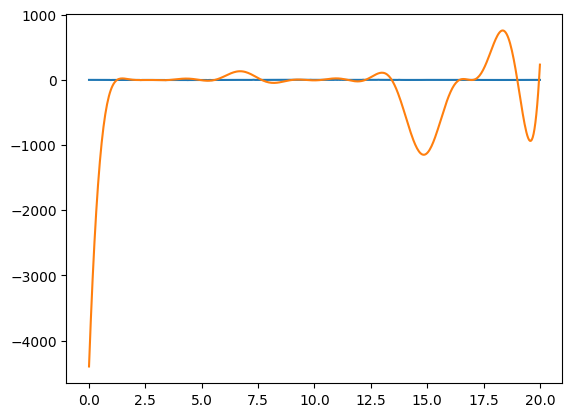

In [44]:
plt.plot(X,y)
plt.plot(X,f)

In [21]:
import gpflow
class GVI_STP_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y, Kernel,
                 inducing=[.0], structure="Tri", alpha=0.5,
                 sigma=.25):
        super().__init__()
        self.X = X
        self.y = y

        # define if we are gonna optimize through the GVI or predictive.
        self.alpha = gpflow.Parameter(alpha, trainable=False)

        self.sigma = gpflow.Parameter(sigma, transform=gpflow.utilities.positive())
        # define the type of objective

        # GP parameters
        self.kernel = Kernel
        self.inducing_variable = inducing
        self.N_u = inducing.shape[0]
        # Variational and GP parameters
        if structure == "Diag":
            self.Var_q = gpflow.Parameter([1.] * self.N_u, transform=gpflow.utilities.positive())
        else:
            self.Var_q = gpflow.Parameter(tf.linalg.eye(self.N_u), transform=gpflow.utilities.triangular())
        self.structure=structure
    tf.keras.backend.set_floatx('float64')

    # needed for the class
    def maximum_log_likelihood_objective(self):
        pass


    def log_likelihood_loss(self, y, mu_f, sigma_f):
        loss = 0.5 * tf.transpose(y - mu_f) @ (y - mu_f) * (self.sigma ** (-2) )
        loss += len(y) * tf.math.log(self.sigma)
        loss += 0.5 * self.sigma ** (-2) * tf.reduce_sum(sigma_f)
        return loss

    def GVI_step(self):
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu + jitter)

        # Variational covariances
        if self.structure == "Diag":
            Sigma_u = tf.linalg.diag(self.Var_q)
        else:
            Sigma_u = self.Var_q @ tf.transpose(self.Var_q)

        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)

        precision_mid = self.alpha * Sigma_a_inv + (
                        K_uu_inv @ K_uf @ K_fu @ K_uu_inv) / self.sigma ** 2 
        q1 = tf.linalg.inv(precision_mid + jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf, self.y) / (self.sigma ** 2) 
        # Compute mu_u
        mu_u = tf.matmul(q1, q2)
        
        #loss
        residual = self.y - K_fu @ K_uu_inv @ mu_u
        residual = tf.cast(residual, tf.float64)
        print(residual.dtype, self.sigma.dtype)
        T1 = K_uu_inv @ (K_uf @ K_fu)
        T2 = T1 @ (K_uu_inv @ Sigma_u)

        term1 = 0.5 * tf.reduce_sum(tf.square(residual)) * (
                        self.sigma ** -2) + 0.5 *  (
                           N*tf.squeeze(self.kernel.variance)- tf.linalg.trace(T1) + tf.linalg.trace(
                            T2)) + N * tf.math.log(self.sigma)
        #divergence
        divergence = self.renyi_gauss_student_objective_B_gevd(
    mu_f=tf.squeeze(mu_u),   # ensure vector
    Sigma_f=Sigma_u,
    K=K_uu,
    nu=5.0,                  # or make this a class param
    alpha=self.alpha,
    num_r_samples=128
)
        loss = tf.squeeze(term1 + divergence)

        return loss




    def predict_ins(self):
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        # Constants
        N = tf.cast(tf.shape(self.X)[0], tf.float64)
        I_M = tf.eye(self.N_u, dtype=tf.float64)
        
        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu + jitter)

        # Variational covariances
        if self.structure == "Diag":
            Sigma_u = tf.linalg.diag(self.Var_q)
        else:
            Sigma_u = self.Var_q @ tf.transpose(self.Var_q)
        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)

        precision_mid = self.alpha * Sigma_a_inv + (
                        K_uu_inv @ K_uf  @ K_fu @ K_uu_inv)*self.sigma ** 2
        q1 = tf.linalg.inv(precision_mid + jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf, (self.y)) / (self.sigma ** 2)
        self.mu_u = tf.matmul(q1, q2)
        self.Sigma_u = Sigma_u

    def renyi_gauss_student_objective_B_gevd(self, mu_f, Sigma_f, K, nu, alpha, num_r_samples=256, jitter=1e-6):
        """
        Computes D_alpha(q||p) for Objective B (q(f) q(r), q(r)=p(r)) using GEVD trick.
        """
        n = tf.shape(K)[0]
        dtype = K.dtype
        I = tf.eye(n, dtype=dtype)
        jitter = 0.00001
    
        # Cholesky of K
        L = tf.linalg.cholesky(K + jitter * I)
    
        # Transform Sigma_f into K^{-1/2} basis
        K_inv_sqrt = tf.linalg.inv(L)
        tilde_Sigma = K_inv_sqrt @ Sigma_f @ tf.transpose(K_inv_sqrt)
    
        # Eigen-decomposition
        eigvals, V = tf.linalg.eigh(tilde_Sigma)
        lam = tf.maximum(eigvals, 0.0)  # ensure nonneg
    
        # transform mean into eigenbasis
        mu_f_col = tf.expand_dims(mu_f, -1)                   # [n,1]
        v_col = tf.transpose(V) @ (tf.transpose(L) @ mu_f_col)  # [n,1]
        v = tf.squeeze(v_col, -1)                             # [n]
    
        # log|Sigma_f|
        _, logdet_Sf = tf.linalg.slogdet(Sigma_f + jitter*I)
    
        # sample r ~ InvGamma(nu/2, nu/2)
        gamma_samples = tf.random.gamma([num_r_samples], alpha=nu/2.0, beta=nu/2.0, dtype=dtype)
        r_samples = 1.0 / gamma_samples   # [S]
    
        # compute inside expectation
        def body(r_j):
            # M = I + (alpha/(nu*r)) Lambda
            M_diag = 1.0 + (alpha/(nu*r_j)) * lam
            logdet_M = tf.reduce_sum(tf.math.log(M_diag))
    
            invM_diag = 1.0 / M_diag
            quad_form = tf.reduce_sum(invM_diag * (v**2))
    
            return -0.5*logdet_M - (alpha/(2.0*nu*r_j))*quad_form
    
        vals = tf.map_fn(body, r_samples)
    
        # log expectation via log-mean-exp trick
        m = tf.reduce_max(vals)
        log_E = m + tf.math.log(tf.reduce_mean(tf.exp(vals - m)))
    
        logJ = -0.5*logdet_Sf + log_E
        D_alpha = (1.0/(alpha-1.0)) * logJ
        return D_alpha


    def internal_opt(self, n_it=10):
        optimizer = tf.optimizers.Adam(learning_rate=0.01)
        for i in range(n_it):
            with tf.GradientTape(persistent=True) as tape:
                loss = self.GVI_step()
            grads = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))
        opt = gpflow.optimizers.Scipy()
        opt.minimize(self.GVI_step, self.trainable_variables)

    def predict_out(self, Xnew):
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_xu = self.kernel(Xnew, self.inducing_variable)
        
        K_uu_inv = tf.linalg.inv(K_uu)

             # compute variance
        f_var =self.kernel(Xnew, Xnew) - K_xu @ K_uu_inv  @ tf.transpose(
            K_xu) + K_xu @ K_uu_inv @ self.Sigma_u @ K_uu_inv @ tf.transpose(
            K_xu)

        return K_xu @ K_uu_inv @ self.mu_u,tf.linalg.diag_part(f_var)




In [22]:
N=X.shape[0]
Z =X[np.random.choice(N, 20, replace=False), :]
kernel = gpflow.kernels.SquaredExponential(lengthscales=1.0, variance=1.0)
inducing_variable = gpflow.Parameter(Z,trainable=False)
model = GVI_STP_alpha(X,y,kernel,inducing_variable)
model.internal_opt()
model.predict_ins()
f,s=model.predict_out(X)

<dtype: 'float64'> <dtype: 'float64'>


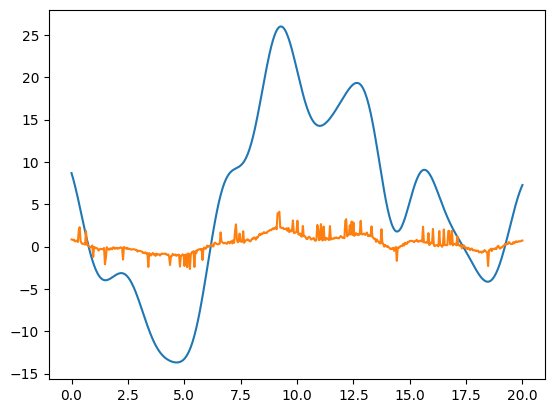

In [24]:
plt.plot(X,f)
plt.plot(X,y)

In [20]:
model.trainable_variables

(<tf.Variable 'fill_triangular:0' shape=(210,) dtype=float64, numpy=
 array([ 4.78429539e-01, -2.74256623e-02,  4.32826708e-02, -7.75681198e-02,
        -1.68004359e-02,  4.65153141e-02,  9.65674503e-02,  4.31748935e-02,
         7.17166228e-02, -6.18849427e-02,  7.26972850e-02, -9.30812895e-02,
         1.12837393e-02,  3.40370079e-02,  3.87127450e-02, -6.86654492e-03,
         7.17766581e-02,  5.95502058e-02, -8.95277027e-02, -4.58219662e-02,
         3.83440929e-01, -1.73948691e-03,  4.61436039e-03, -5.36110079e-02,
         1.35992467e-02,  1.68452981e-02, -4.83862712e-02,  5.77531829e-02,
        -5.48892408e-02,  1.03764436e-01,  4.03605690e-01, -4.70927069e-02,
         1.31059384e-03, -6.68596121e-03,  1.98496876e-02, -1.61339070e-02,
         8.32567498e-02,  3.64092446e-02,  4.99434354e-02, -2.32763249e-02,
         1.54025643e-02,  2.78180791e-01, -1.32356437e-02,  4.37856723e-02,
         9.45525089e-02,  1.82840268e-02,  1.87106051e-02,  1.94887929e-02,
        -1.59965381